# Imports and helper functions

In [52]:
!pip install mlforecast

In [53]:
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
import os

# MLforecast related imports
from mlforecast import MLForecast
import lightgbm as lgb
from utilsforecast.plotting import plot_series

In [54]:
def load_imputed_results(filename: str = "imputed_results.npz") -> dict:
    loaded = np.load(filename)
    # np.load on an NPZ file returns a dictionary-like object.
    # Convert to a plain Python dict for convenience.
    return {key: loaded[key] for key in loaded.keys()}

def load_originals(load_path: str):
    """
    Loads the saved train datasets along with the numpy arrays.

    Parameters:
    - load_path (str): Path to load the files from.

    Returns:
    - train_data (pl.DataFrame)
    - X (np.ndarray)
    - y (np.ndarray)

    """

    # Load Polars DataFrames
    train_data = pl.read_parquet(f"{load_path}/train_data.parquet")

    # Load numpy arrays
    X = np.load(f"{load_path}/X.npy")
    y = np.load(f"{load_path}/y.npy")

    return train_data, X, y

def resample_climate(original_df, every='1h'):

    resampled_df = (original_df
                     .group_by_dynamic("Date Time", every=every)
                     .agg(pl.all()
                          .mean()))

    return resampled_df

# Load original, "simple" imputed and PyPots imputed data

In [55]:
# imputed_path="/kaggle/input/cap-pygrinder-pypots/imputed_results_6h.npz"
imputed_path="/kaggle/input/cap-pygrinder-pypots/imputed_results_10min.npz"

originals_path = "/kaggle/input/cap-pygrinder-pypots/originals"

imputed_results = load_imputed_results(imputed_path)
train_data, X, y = load_originals(originals_path)

In [56]:
imputed_results.keys()

dict_keys(['mean_mcar', 'mean_mnar', 'interp_mcar', 'interp_mnar', 'knn_mcar', 'knn_mnar', 'saits_mcar', 'saits_mnar'])

In [57]:
RESAMPLING = '10min' # same setups as PyPots notebook
horiz = 144 #1 week (6h resampled)  #144 1 day for 10min resample        #math.ceil(data.shape[0] * 0.05) #Last 5% of dataset for later validation of forecast
TARGET = "p (mbar)"

# MLForecast Forecasting benchmark

## Feature engineering

In [58]:
def restore_and_engineer_features(
    X_imputed: np.ndarray,
    y: np.ndarray,
    original_data: pl.DataFrame,
    method_name: str
) -> pl.DataFrame:
    """
    Restore an imputed feature matrix X_imputed as a Polars DataFrame, merge
    with original timestamps and target y, and create engineered features.
    
    Parameters
    ----------
    X_imputed : np.ndarray
        Imputed feature matrix of shape (n_samples, n_features).
    y : np.ndarray
        Original target array of shape (n_samples,).
    original_data : pl.DataFrame
        The original dataset (with columns 'Date Time', and other features).
    method_name : str
        Identifier for the imputation method (e.g. "knn_mcar", "knn_mnar").
        
    Returns
    -------
    pl.DataFrame
        A Polars DataFrame containing:
          - "Date Time"
          - restored target
          - Restored feature columns
          - Engineered features (time-based and weather context)
    """
    # Identify the feature columns from original data (excluding Date Time)
    feature_cols = original_data.drop(["Date Time", TARGET]).columns
    
    if X_imputed.shape[1] != len(feature_cols):
        raise ValueError("Mismatch between imputed data width and expected feature columns.")
    if X_imputed.shape[0] != len(y):
        raise ValueError("Mismatch between imputed data length and target length (y).")
    
    # Convert the imputed numpy array into Polars Dataframe
    df_imputed = pl.from_numpy(X_imputed, schema=feature_cols)    

    # Build a new DataFrame: Timestamps + imputed features + target
    df_restored = df_imputed.with_columns([
                    pl.Series(original_data["Date Time"]).alias("Date Time"),
                    pl.Series(y).alias(TARGET),
                ]).explode(TARGET)
    
    # Feature Engineering
    # -------------------
    # 1. Basic time features
    df_restored = (
        df_restored
        .with_columns([
            pl.col("Date Time").dt.year().alias("year"),
            pl.col("Date Time").dt.month().alias("month"),
            pl.col("Date Time").dt.day().alias("day"),
            pl.col("Date Time").dt.hour().alias("hour"),
            pl.col("Date Time").dt.minute().alias("minute"),
            ((pl.col("Date Time").dt.month() - 1) // 3 + 1).alias("quarter"),
        ])
    )
    
    # 2. Cyclical features for hour and month
    #    hour_sin = sin(2π*hour/24), hour_cos = cos(2π*hour/24)
    #    month_sin = sin(2π*month/12), month_cos = cos(2π*month/12)
    df_restored = (
        df_restored
        .with_columns([
            ( (pl.col("hour") / 24.0) * 2.0 * math.pi ).sin().alias("hour_sin"),
            ( (pl.col("hour") / 24.0) * 2.0 * math.pi ).cos().alias("hour_cos"),
            ( (pl.col("month") / 12.0) * 2.0 * math.pi ).sin().alias("month_sin"),
            ( (pl.col("month") / 12.0) * 2.0 * math.pi ).cos().alias("month_cos"),
        ])
    )

    df_restored = (df_restored.with_columns(pl.lit("1")
                .alias("unique_id")
                .cast(pl.Int8)))
    
    return df_restored

In [59]:
def generate_engineered_datasets(X, y, train_data, imputed_results):
    """
    Restores and engineers features for the original and imputed datasets.

    Args:
        X: Original feature dataset.
        y: Target variable.
        train_data: Training data used for restoration and engineering.
        imputed_results: Dictionary of imputed datasets with method names as keys.

    Returns:
        dict: A dictionary where keys are method names and values are the corresponding engineered dataframes.
    """
    engineered_datasets = {
        "original": restore_and_engineer_features(X, y, train_data, method_name="original")
    }

    for method, imputed_data in imputed_results.items():
        engineered_datasets[method] = restore_and_engineer_features(imputed_data, y, train_data, method_name=method)

    return engineered_datasets

In [60]:
engineered_data = generate_engineered_datasets(X, y, train_data, imputed_results)

In [61]:
lgb_params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'random_state': 23,
    'verbosity': -1,
    'n_estimators': 100
}

lgb_model = lgb.LGBMRegressor(**lgb_params)

In [62]:
fcst = MLForecast(
    models=lgb_model,
    freq=RESAMPLING,
    #lags=[1, 2, 3, 4, 5, 6],
    num_threads=6,
    )
fcst

MLForecast(models=[LGBMRegressor], freq=10min, lag_features=[], date_features=[], num_threads=6)

In [63]:
def evaluate_forecast_with_cv(fcst, df_engineered, target_name=TARGET, horizon=150, method_name=None):
    """
    Runs cross-validation, prints RMSE, fits the model, predicts, and plots the forecast.

    Parameters
    ----------
    fcst : MLForecast object
        The MLForecast instance (already configured with models) to be used for cross-validation and prediction.
    df_engineered : pd.DataFrame
        The dataframe containing all the engineered features. Must have columns:
          - 'unique_id': identifies different time series
          - 'Date Time' (or your time column) which will be renamed to 'ds'
          - The target column (commonly passed in with the name you used when calling restore_and_engineer_features)
    horizon : int, optional
        Number of steps for out-of-sample forecast. Defaults to 150.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure produced by plot_series.
    """
    # Rename columns to the MLforecast convention
    # Assuming there's a TARGET column in df_engineered that needs to be renamed to 'y'
    # and a column called "Date Time" that should become 'ds'. 
    # If your actual column names differ, adjust accordingly.
    final_data = df_engineered.rename({
        'Date Time': 'ds',
        target_name: "y",
    }).to_pandas()

    # Ensure correct ordering
    final_data = final_data.sort_values(['unique_id', 'ds']).reset_index(drop=True)

    # Create validation split
    valid = final_data.tail(horizon)
    train = final_data.drop(valid.index)

    # Cross-validation with n_windows=5, h=5 as in your example
    cv_results = fcst.cross_validation(train, n_windows=5, h=horizon, static_features=[])

    # Compute RMSE from cross-validation
    # Here we assume 'LGBMRegressor' is the model's prediction column in cv_results;
    # if you have different model names or multiple models, adapt accordingly.
    cv_rmse = sqrt(mean_squared_error(cv_results['y'], cv_results['LGBMRegressor']))
    print(f"\n{method_name}\nCross-Validation RMSE (5-windows, 5-steps ahead): {cv_rmse:.4f}")

    # Fit model on the training data
    fcst.fit(train, static_features=[], fitted=True)

    # Forecast out-of-sample
    predictions = fcst.predict(horizon, X_df=valid)

    # Merge predictions with actuals
    results = valid[['unique_id', 'ds', 'y']].merge(predictions, on=['unique_id', 'ds'], how='left')

    # Generate forecast plot
    fig = plot_series(forecasts_df=results)

    os.makedirs('./results', exist_ok=True)
    fig.savefig(f'results/{method_name}_forecast_resampling-{RESAMPLING}_horiz-{horiz}_{TARGET}.png', bbox_inches='tight')

    return fig

In [64]:
HORIZON = horiz

In [65]:
def evaluate_forecasts(fcst, engineered_data, horizon):

    evaluation_results = {
        method: evaluate_forecast_with_cv(fcst, df, horizon=horizon, method_name=method)
        for method, df in engineered_data.items()
    }
    return evaluation_results

In [66]:
forecast_results = evaluate_forecasts(fcst, engineered_data, HORIZON)


original
Cross-Validation RMSE (5-windows, 5-steps ahead): 1.1136

mean_mcar
Cross-Validation RMSE (5-windows, 5-steps ahead): 2.8004

mean_mnar
Cross-Validation RMSE (5-windows, 5-steps ahead): 4.8352

interp_mcar
Cross-Validation RMSE (5-windows, 5-steps ahead): 1.0133

interp_mnar
Cross-Validation RMSE (5-windows, 5-steps ahead): 0.9917

knn_mcar
Cross-Validation RMSE (5-windows, 5-steps ahead): 2.7442

knn_mnar
Cross-Validation RMSE (5-windows, 5-steps ahead): 5.2036

saits_mcar
Cross-Validation RMSE (5-windows, 5-steps ahead): 1.3442

saits_mnar
Cross-Validation RMSE (5-windows, 5-steps ahead): 0.9949


## Original

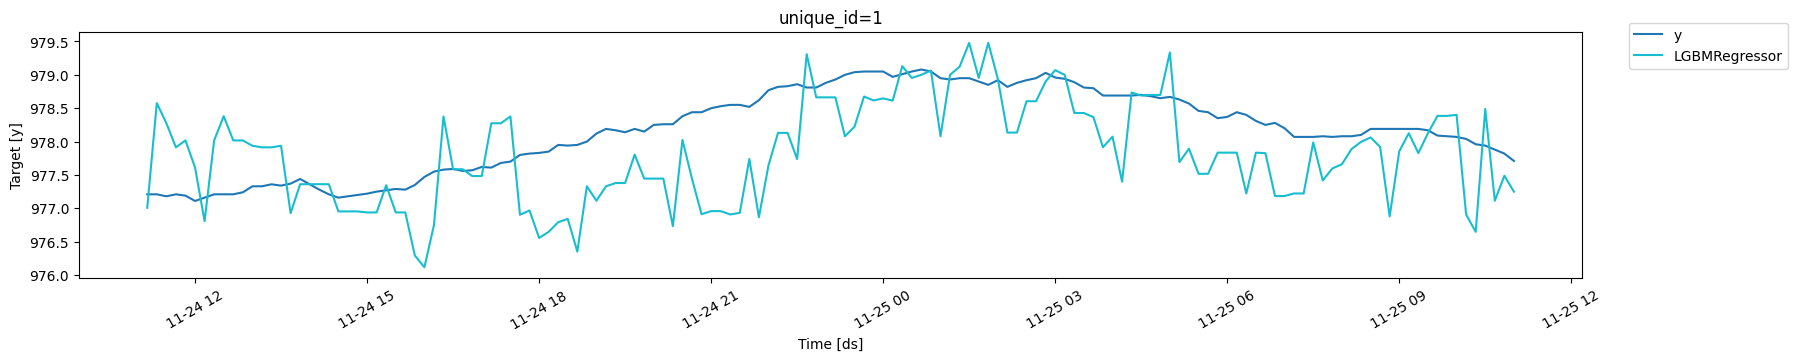

In [67]:
forecast_results["original"]

## MCAR Imputed

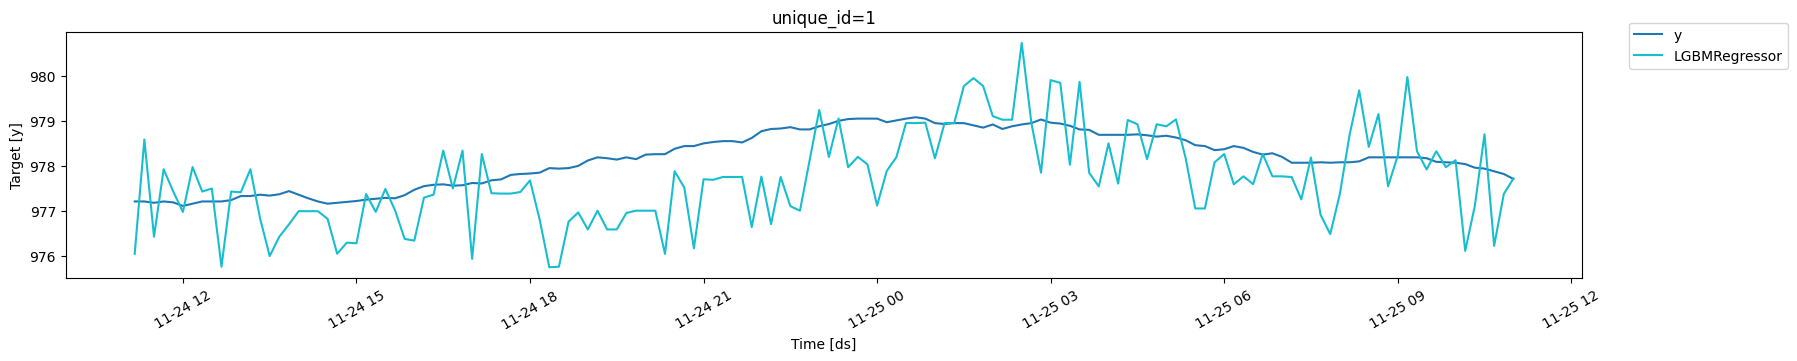

In [68]:
forecast_results["saits_mcar"]

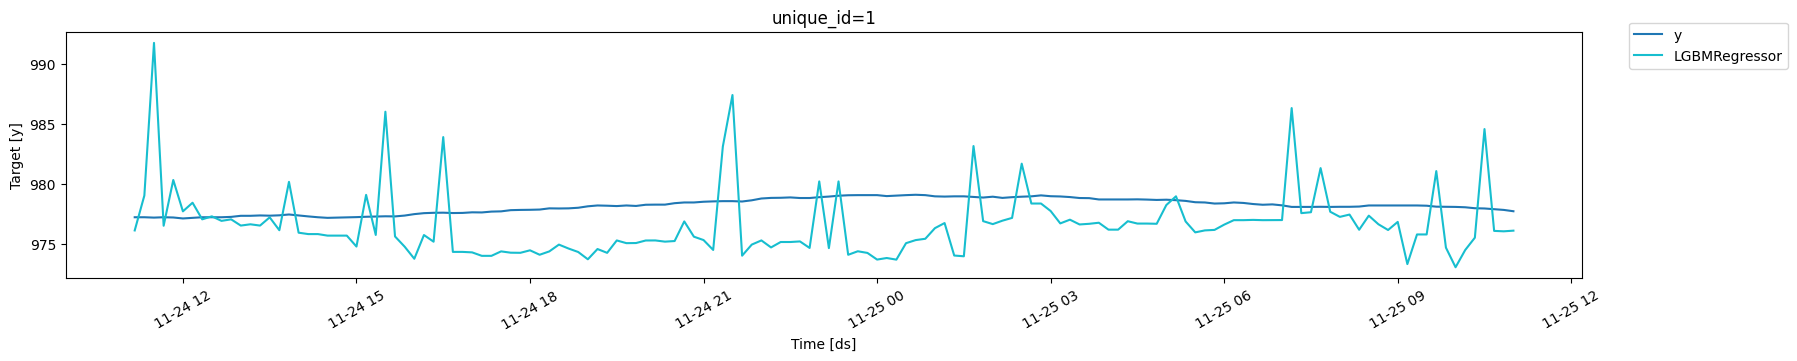

In [69]:
forecast_results["knn_mcar"]

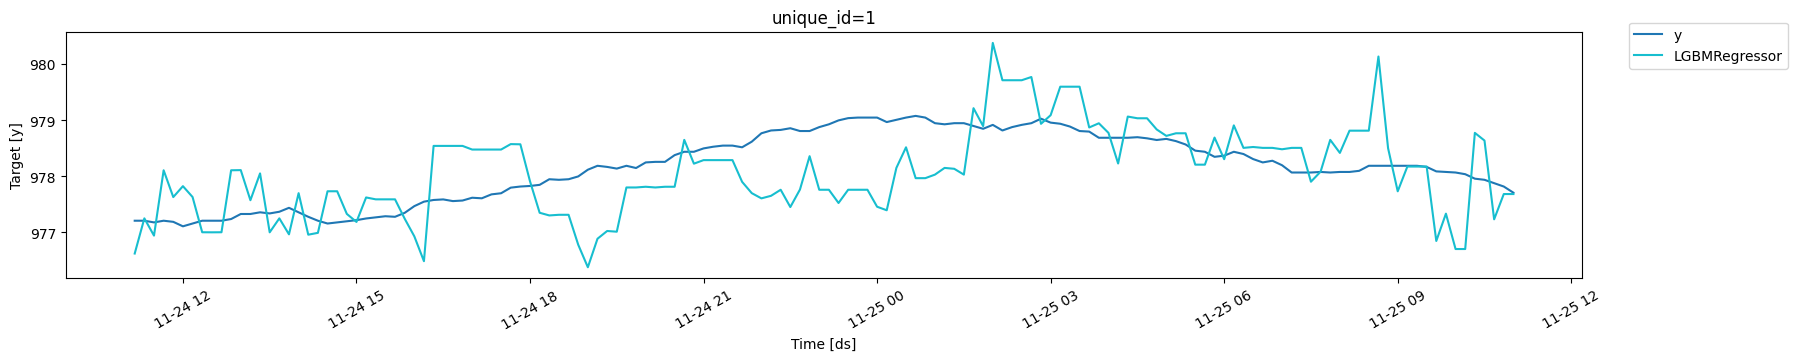

In [70]:
forecast_results["interp_mcar"]

## MNAR Imputed

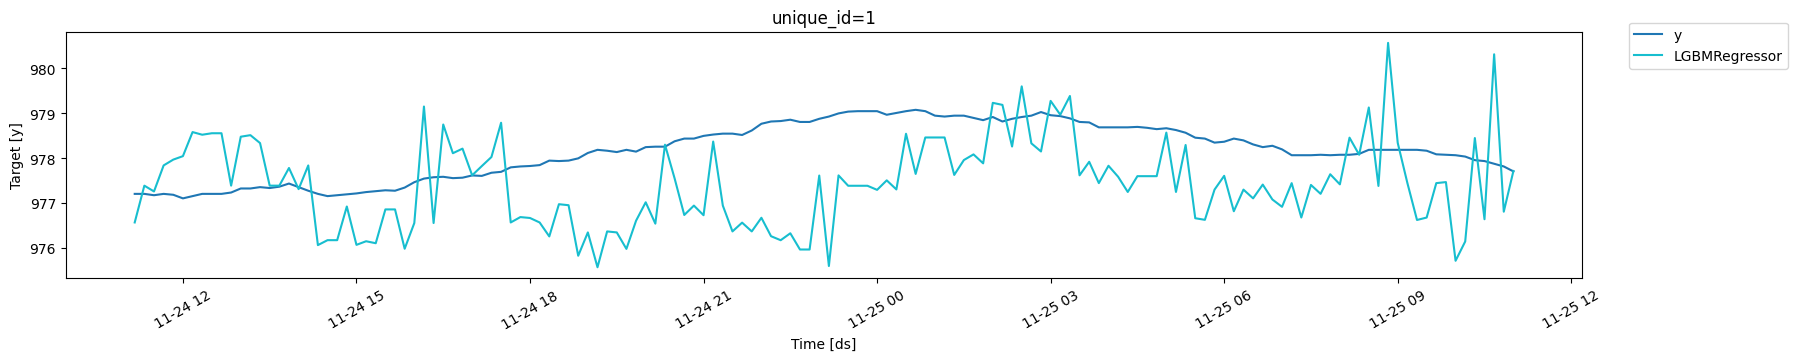

In [71]:
forecast_results["saits_mnar"]

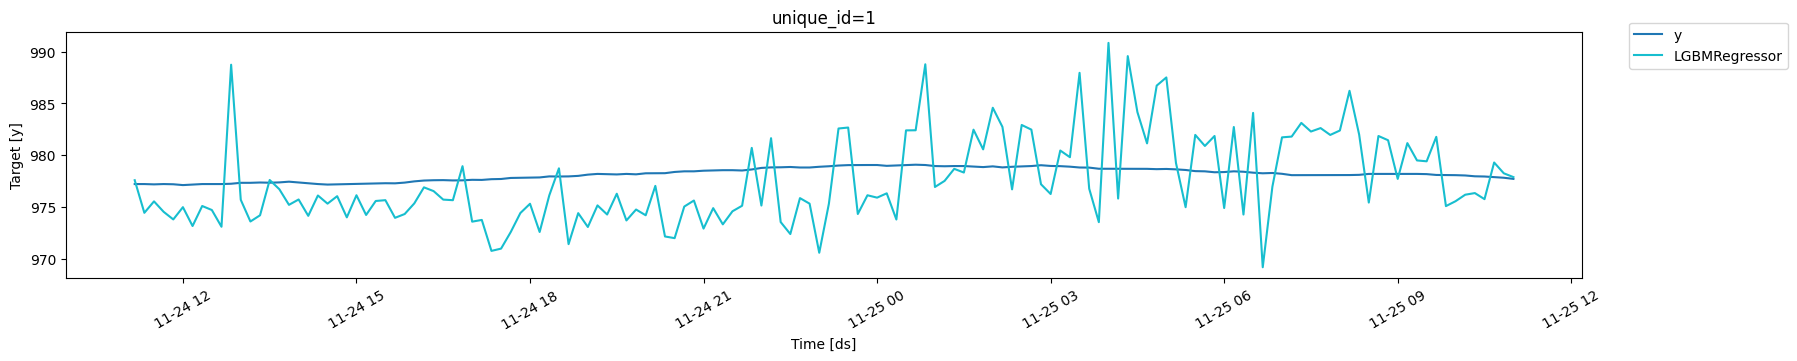

In [72]:
forecast_results["knn_mnar"]

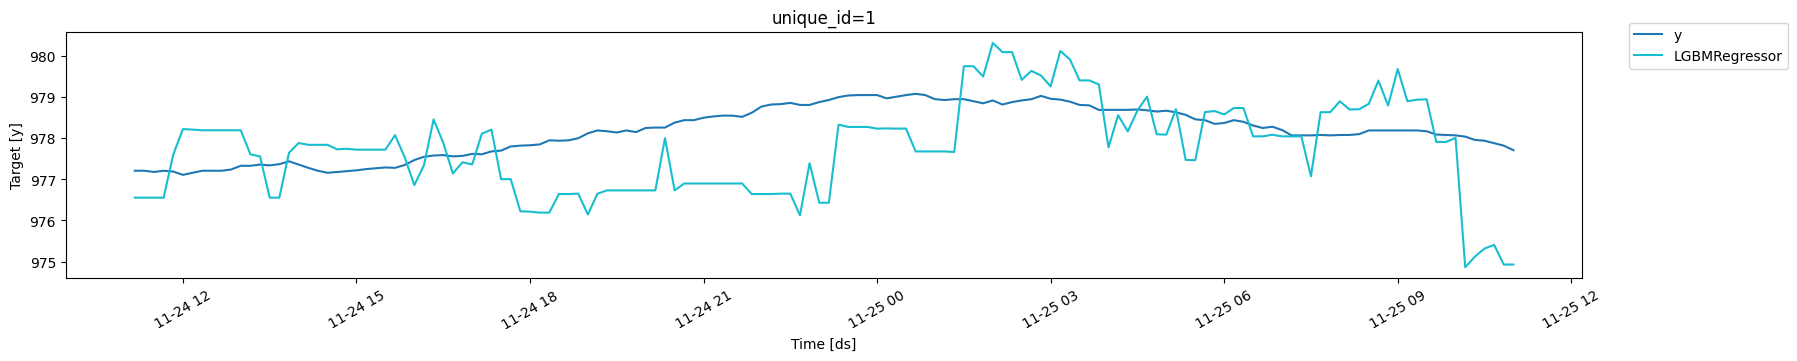

In [73]:
forecast_results["interp_mnar"]

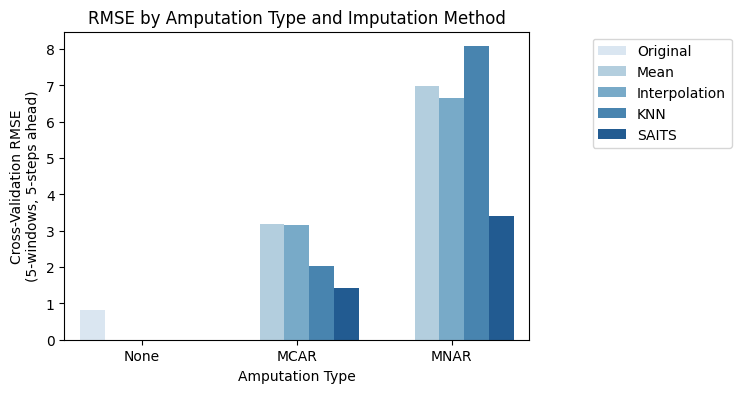

<Figure size 640x480 with 0 Axes>

In [74]:
data = {
    "Method": [
        "Original", "Mean", "Mean", "Interpolation", "Interpolation", 
        "KNN", "KNN", "SAITS", "SAITS"
    ],
    "Amputation": [
        "None", "MCAR", "MNAR", "MCAR", "MNAR", 
        "MCAR", "MNAR", "MCAR", "MNAR"
    ],
    "RMSE": [
        1.1136, 2.8004, 4.8352, 1.0133, 0.9917, 
        2.7442, 5.2036, 1.3442, 0.9949
    ]
}

df = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(6, 4))
palette = sns.color_palette("Blues", n_colors=len(df["Method"].unique()))

# Plot grouped bars
sns.barplot(x="Amputation", y="RMSE", hue="Method", data=df, palette=palette)

# Labels and title
plt.xlabel("Amputation Type")
plt.ylabel("Cross-Validation RMSE\n(5-windows, 5-steps ahead)")
plt.title("RMSE by Amputation Type and Imputation Method")
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1))

# Show the plot
plt.show()
plt.savefig(f'results/metrics_forecast_resampling-{RESAMPLING}_horiz-{horiz}_{TARGET}.png', bbox_inches='tight')